In [1]:
''' mainly used to make sure that C nmr works better than HSQC'''

import torch
torch.set_printoptions(precision=10)

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from models.optional_input_ranked_transformer import OptionalInputRankedTransformer
from datasets.optional_2d_folder_dataset import OptionalInputDataModule
import yaml
from pytorch_lightning.loggers import TensorBoardLogger
torch.set_float32_matmul_precision('medium')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load model 

model_path = Path("/root/MorganFP_prediction/reproduce_previous_works/average_3/model_sizes/flexible_384_trail1")
hyperpaerameters_path = model_path / "hparams.yaml"

checkpoint_path = model_path / "checkpoints/epoch=41-step=35994.ckpt"
with open(hyperpaerameters_path, 'r') as file:
    hparams = yaml.safe_load(file)
del hparams['checkpoint_path'] # prevent double defition of checkpoint_path
hparams['use_peak_values'] = False

model = OptionalInputRankedTransformer.load_from_checkpoint(checkpoint_path, **hparams)
model.change_ranker_for_testing()


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


In [3]:
datamodule = OptionalInputDataModule(dir="/workspace/SMILES_dataset", FP_choice=hparams["FP_choice"], input_src=["HSQC", "oneD_NMR"], batch_size=1, parser_args=hparams)

In [4]:
datamodule.setup("predict")

loader_all_inputs, loader_HSQC_H_NMR, loader_HSQC_C_NMR, loader_only_hsqc, loader_only_1d, loader_only_H_NMR, loader_only_C_NMR = \
    datamodule.predict_dataloader()
    
model=model.to("cuda")

In [5]:
# set up ranking set

import pickle 
choice = "test"
fp_path = "R0_to_R4_reduced_FP"
index_to_smiles = pickle.load(open(f'/workspace/SMILES_dataset/{choice}/SMILES/index.pkl', 'rb'))
folder_base = Path("/workspace/SMILES_dataset")

choice_path = folder_base / choice / fp_path
print(f"=== {choice_path}")


all_FP_indices_in_folder = pickle.load(open(f'/root/MorganFP_prediction/reproduce_previous_works/smart4.5/datasets/{choice}_indices_of_full_info_NMRs.pkl', 'rb'))
all_added_smiles = set()
all_FP_indices_to_be_added = []
for i in all_FP_indices_in_folder:
    smile = index_to_smiles [int(i.split(".")[0])]
    if smile not in all_added_smiles:
        all_added_smiles.add(smile)
        all_FP_indices_to_be_added.append(i)
        
sorted_file_indices  = [int(file.split(".")[0]) for file in sorted(all_FP_indices_to_be_added)]
index_to_chemical_names = pickle.load(open(f'/workspace/SMILES_dataset/{choice}/Chemical/index.pkl', 'rb'))

smiles_and_names = [(index_to_smiles[file_index], index_to_chemical_names[file_index]) for file_index in sorted_file_indices]
len(smiles_and_names)


=== /workspace/SMILES_dataset/test/R0_to_R4_reduced_FP


3930

In [6]:
# visualize the all input one 
import os 

chemical_names_lookup = pickle.load(open(f'/workspace/SMILES_dataset/test/Chemical/index.pkl', 'rb'))
# chemical_names_lookup[2288]

In [7]:
all_file_indices = [int(i.split(".")[0]) for i in loader_all_inputs.dataset.files]
all_chemicals = [chemical_names_lookup[file_idx] for file_idx in all_file_indices]
for i, chemical in enumerate(all_chemicals):
    print(i, chemical)

0 hippuristerone L
1 128420-44-0
2 Cudraflavone B
3 dihydrohalichondramide
4 160476
5 isonaamidine-A
6 Litseaverticillol C
7 Periglaucine C
8 2,4,6-tribromoindole
9 (3R,3aS,4R,7S,7aS)-7-Bromo-3-[(1S)-1-hydroxy-2-methyl-2-propen-1-yl]-4,7a-dimethyloctahydro-1H-inden-4-ol
10 oxaloterpin A
11 44259629
12 Alpha-2',3,4,4'-Pentahydroxydihydrochalcone
13 (16S)-17-hydroxy-ent-kauran-19-oic acid
14 pestalotiollide B
15 (-)-Hydnocarpin
16 asterolaurin I
17 Methyl (5Z,7E,14Z)-12-(acetoxymethyl)-9-oxoprosta-5,7,10,14-tetraen-1-oate
18 139163-16-9
19 UNPD159195
20 Tricalysioside U
21 2-Hydroxymethyl-6-Methoxy-Tetrahydro-Pyran-3,4,5-Triol
22 12-a-O-acetylhyrtiolide
23 147444-03-9
24 oryzamutaic acid G
25 isomandapamate
26 brevetoxin A (GB-1)
27 antadiosbulbin B
28 (2S)-7,4'-Dihydroxy-8-Prenylflavan
29 NCGC00385124-01!1-(3,4-dimethoxyphenyl)-2-[4-[5-[4-[1-(3,4-dimethoxyphenyl)-1-hydroxypropan-2-yl]oxy-3-methoxyphenyl]-3,4-dimethyloxolan-2-yl]-2-methoxyphenoxy]propan-1-ol
30 7893/7 corrected
31 4,4,14

In [16]:
which_compound = 127
filename = loader_all_inputs.dataset.files[which_compound]

f_path = os.path.join(loader_all_inputs.dataset.dir, "oneD_NMR", filename)
if os.path.exists(f_path):
    c_tensor, h_tensor = torch.load(f_path)
    
hsqc = torch.load(f_path.replace("oneD_NMR", "HSQC"))

# print(f_path)
chemical_names_lookup = pickle.load(open(f'/workspace/SMILES_dataset/test/Chemical/index.pkl', 'rb'))
chemical_names_lookup[int(filename.split(".")[0])]

'(1S,2R,5S,6S,7S,9R,12R)-5-Acetoxy-12-hydroxy-2,6,10,10-tetramethyl-11-oxatricyclo[7.2.1.0~1,6~]dodec-7-yl benzoate'

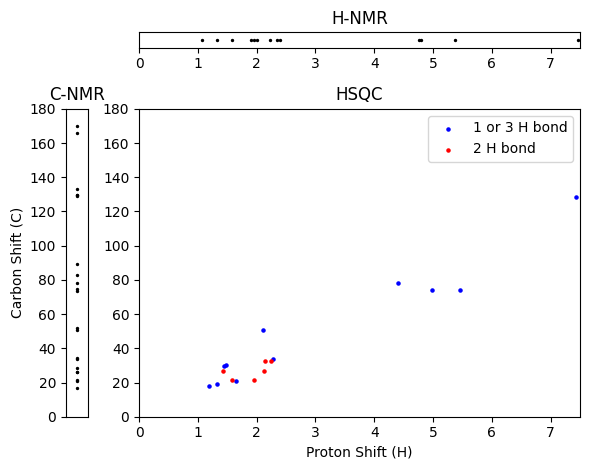

In [17]:
import matplotlib.pyplot as plt




# 
import matplotlib.gridspec as gridspec


# Create a 2x2 grid for subplots
fig = plt.figure(figsize=(6, 4.8))  # Overall figure size
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 20], width_ratios=[1, 20])

# Create subplots in different locations and sizes
pos = hsqc[hsqc[:,2]>0]
neg = hsqc[hsqc[:,2]<0]
ax1 = fig.add_subplot(gs[1, 1])  # Takes up the first row
ax1.scatter(pos[:,1], pos[:,0], c="blue", label="1 or 3 H bond", s=5)
ax1.scatter(neg[:,1], neg[:,0], c="red", label="2 H bond", s=5)
ax1.set_title("HSQC")
ax1.set_xlabel('Proton Shift (H)')  # X-axis label
ax1.set_xlim([0, 7.5])
ax1.set_ylim([0, 180])
ax1.legend()


ax2 = fig.add_subplot(gs[1, 0])  # Smaller subplot
ax2.scatter( torch.ones(len(c_tensor)), c_tensor, c="black", s=2)
ax2.set_ylim([0, 180])
ax2.set_title("C-NMR")
ax2.set_ylabel('Carbon Shift (C)')
ax2.set_xticks([])

ax3 = fig.add_subplot(gs[0, 1])  # Smaller subplot
ax3.scatter(h_tensor, torch.ones(len(h_tensor)),c="black", s=2)
ax3.set_xlim([0, 7.5])
ax3.set_title("H-NMR")
ax3.set_yticks([])

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()



In [19]:
for idx, batch in enumerate(loader_all_inputs):
    inputs, (smiles_chemical_name) = batch
    
    batch[0] = batch[0].to("cuda")
    topk_idx_all_spec = model.predict_step(batch, idx, dataloader_idx=0)
    # if idx <= 1: continue
    break

In [11]:
# for idx, batch in enumerate(loader_only_C_NMR):
#     inputs, (smiles_chemical_name) = batch
    
#     batch[0] = batch[0].to("cuda")
#     topk_idx_C_nmr = model.predict_step(batch, idx, dataloader_idx=6)
#     # if idx <= 1: continue
#     break

In [12]:
# for idx, batch in enumerate(loader_only_hsqc):
#     inputs, (smiles_chemical_name) = batch
    
#     batch[0] = batch[0].to("cuda")
#     topk_idx_HSQC = model.predict_step(batch, idx, dataloader_idx=3)
#     # if idx <= 1: continue
#     break


compound number 1
Ground truth smiles CC(=O)OC(C(C)=C1C(O)CC2C3CCC4CC(=O)CCC4(C)C3CCC12C)C(C)C(C)C(C)(C)O
Chemical name hippuristerone L


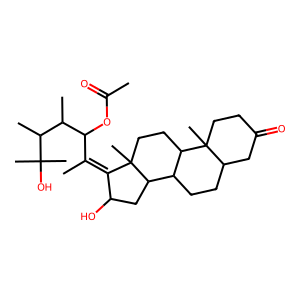

Following is top-1 prediction using all three spectra: hippuristerone L, smiles: CC(=O)OC(C(C)=C1C(O)CC2C3CCC4CC(=O)CCC4(C)C3CCC12C)C(C)C(C)C(C)(C)O


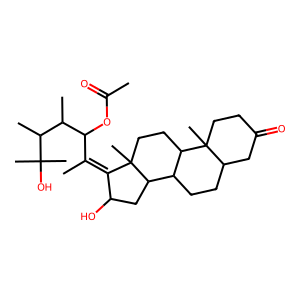

Following is top-2 prediction using all three spectra: hippuristerone J, smiles: CC(=O)OCC(C)(O)C(C)C(C)C(OC(C)=O)C1(COC(C)=O)OC12C(O)CC1C3CCC4CC(=O)CCC4(C)C3CCC12C


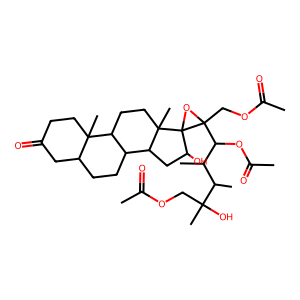

Following is top-3 prediction using all three spectra: 3,6-diketosteroid, smiles: CC(C)CC=CC(C)(O)C1CCC2C3CC(=O)C4CC(=O)CCC4(C)C3CCC21C


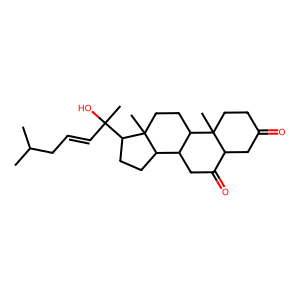

Following is top-4 prediction using all three spectra: Lepranthin, smiles: CC(=O)OC(C)CC1CC(OC(C)=O)C(C)C(O)C(C)C(=O)OC(CC(C)OC(C)=O)CC(OC(C)=O)C(C)C(O)C(C)C(=O)O1


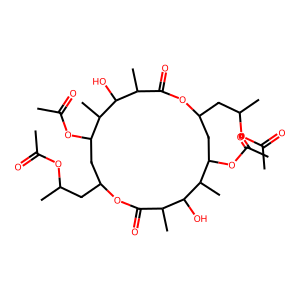

Following is top-5 prediction using all three spectra: 16-hydroxy-5-pregnadien-3-one 16-acetate, smiles: C=CC1C(OC(C)=O)CC2C3CCC4CC(=O)C=CC4(C)C3CCC12C


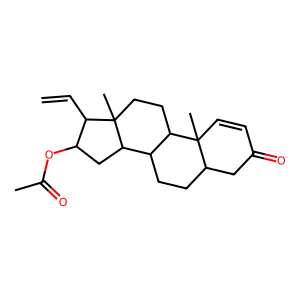

===


In [13]:
smiles, names = zip(*smiles_chemical_name)
for i in range(len(smiles)):
    print()
    mol = Chem.MolFromSmiles(smiles[i])

    print("compound number", i+1)
    print(f"Ground truth smiles {smiles[i]}")
    print(f"Chemical name {names[i]}")
    img = Draw.MolToImage(mol)
    img.show()
    
    for idx in range(5):
        pred_smile, pred_name = smiles_and_names[topk_idx_all_spec[idx][i]]
        print(f"Following is top-{idx+1} prediction using all three spectra: {pred_name}, smiles: {pred_smile}")
        mol = Chem.MolFromSmiles(pred_smile)
        img = Draw.MolToImage(mol)
        img.show()
        
        # pred_smile, pred_name = smiles_and_names[topk_idx_C_nmr[idx][i]]
        # print(f"Following is top-{idx+1} prediction using only C NMR: {pred_name}, smiles: {pred_smile}")
        # mol = Chem.MolFromSmiles(pred_smile)
        # img = Draw.MolToImage(mol)
        # img.show()
        
        # pred_smile, pred_name = smiles_and_names[topk_idx_HSQC[idx][i]]
        # print(f"Following is top-{idx+1} prediction using only HSQC: {pred_name}, smiles: {pred_smile}")
        # mol = Chem.MolFromSmiles(pred_smile)
        # img = Draw.MolToImage(mol)
        # img.show()
        
    print("===")

In [14]:
# k = 5

# for idx, batch in enumerate(loader_all_inputs):
#     inputs, (smiles_chemical_name) = batch
    
#     batch[0] = batch[0].to("cuda")
#     topk_idx_all_spec = model.predict_step(batch, idx, dataloader_idx=0)
#     if idx <= k: continue
#     break

# for idx, batch in enumerate(loader_only_C_NMR):
#     inputs, (smiles_chemical_name) = batch
    
#     batch[0] = batch[0].to("cuda")
#     topk_idx_C_nmr = model.predict_step(batch, idx, dataloader_idx=6)
#     if idx <= k: continue
#     break

# for idx, batch in enumerate(loader_only_hsqc):
#     inputs, (smiles_chemical_name) = batch
    
#     batch[0] = batch[0].to("cuda")
#     topk_idx_HSQC = model.predict_step(batch, idx, dataloader_idx=3)
#     if idx <= k: continue
#     break


# smiles, names = zip(*smiles_chemical_name)
# for i in range(len(smiles)):
#     print()
#     mol = Chem.MolFromSmiles(smiles[i])

#     print("compound number", i+1)
#     print(f"Ground truth smiles {smiles[i]}")
#     print(f"Chemical name {names[i]}")
#     img = Draw.MolToImage(mol)
#     img.show()
    
#     for idx in range(1):
#         pred_smile, pred_name = smiles_and_names[topk_idx_all_spec[idx][i]]
#         print(f"Following is top-{idx+1} prediction using all three spectra: {pred_name}, smiles: {pred_smile}")
#         mol = Chem.MolFromSmiles(pred_smile)
#         img = Draw.MolToImage(mol)
#         img.show()
        
#         pred_smile, pred_name = smiles_and_names[topk_idx_C_nmr[idx][i]]
#         print(f"Following is top-{idx+1} prediction using only C NMR: {pred_name}, smiles: {pred_smile}")
#         mol = Chem.MolFromSmiles(pred_smile)
#         img = Draw.MolToImage(mol)
#         img.show()
        
#         pred_smile, pred_name = smiles_and_names[topk_idx_HSQC[idx][i]]
#         print(f"Following is top-{idx+1} prediction using only HSQC: {pred_name}, smiles: {pred_smile}")
#         mol = Chem.MolFromSmiles(pred_smile)
#         img = Draw.MolToImage(mol)
#         img.show()
        
#     print("===")